## Imports
It may be necessary to pip install several packages listed below if you do not currently have them

In [2]:
import os
import cv2
import sys
import glob
import random
import requests
import argparse
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import keras
from keras import __version__
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.models import Model, model_from_json, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input

# imports for LIME
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

import sklearn
import sklearn.datasets
import sklearn.ensemble

import lime
import lime.lime_tabular
from lime import lime_image
from __future__ import print_function

## Download Inception_V3 model
## WARNING: LARGE DOWNLOAD

This download only needs to be done ONCE. You should then save model to json (shown below) and simply load it later (also shown below). This automatically excludes the final dense layer of InceptionV3 so that we can add our own layer and transfer learn.

In [102]:
inception_model = InceptionV3(weights='imagenet', include_top=False)

ValueError: Initializer for variable conv2d_360/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

## Save model to json for later use

In [2]:
# SAVE MODEL TO JSON
model_json = inception_model.to_json()

with open("inception_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
inception_model.save_weights("inception_model.h5")
print("Saved model to disk")

NameError: name 'inception_model' is not defined

## Load from json

In [20]:
# LOAD JSON INTO MODEL
json_file = open('inception_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
inception_model = model_from_json(loaded_model_json)

# load weights into new model
inception_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


## Utils for training

This includes the entire training process from adding a new dense layer (optional) to transfer learning to fine tuning to plotting (optional).

In [4]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt


def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet

    Args:
    base_model: keras model excluding top
    nb_classes: # of classes

    Returns:
    new keras model with last layer
    """
    print('classes', nb_classes)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def setup_to_finetune(model):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.

    note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

    Args:
    model: keras model
    """
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


def train(args, add_layer=True):
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    nb_train_samples = get_nb_files(args.train_dir)
    nb_classes = len(glob.glob(args.train_dir + "/*"))
    validation_steps = get_nb_files(args.val_dir)
    nb_epoch = int(args.nb_epoch)
    batch_size = int(args.batch_size)
    
    print('Training Samples:', nb_train_samples)
    print('Classes:', nb_classes)
    print('Validation Samples:', validation_steps)
    print('Epochs:', nb_epoch)
    print('Batch Size:', batch_size)

    # data prep
    train_datagen =  ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        args.train_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=batch_size,
    )

    validation_generator = test_datagen.flow_from_directory(
        args.val_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=batch_size,
    )

    # setup model
    model = inception_model
    
    # ADD LAST LAYER ONLY IF NECESSARY
    if add_layer:
        model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
    print("Begin Tranfer Learning...")

    history_tl = model.fit_generator(
        train_generator,
        steps_per_epoch=int(nb_train_samples/BAT_SIZE),
        epochs=nb_epoch,
        validation_data=validation_generator,
        validation_steps=int(validation_steps/BAT_SIZE),
        class_weight='auto'
    )
    
    print("Transfer Learning Complete")

    # fine-tuning
    setup_to_finetune(model)
    
    print("Begin Fine-Tuning...")

    history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=int(nb_train_samples/BAT_SIZE),
        epochs=nb_epoch,
        validation_data=validation_generator,
        validation_steps=int(validation_steps/BAT_SIZE),
        class_weight='auto',
    )

    print("Fine-Tuning Complete")
    
    print("Save Model")

    # SAVE MODEL TO JSON
    model_json = model.to_json()
    with open("inception_model_trained.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("inception_model_trained.h5")
    print("Saved model to disk")

    # display training history
    if args.plot:
        plot_training(history_tl)
        plot_training(history_ft)

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

## Set parameters

Specify the number of epochs, batch size, size of fully connected layer we add, and the number of layers to freeze during transfer learning.

In [ ]:
IM_WIDTH, IM_HEIGHT = 299, 299 # fixed size for InceptionV3
NB_EPOCHS = 5 # NOTE: It will run this many epochs on both Transfer Learning AND Fine-Tuning
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172

class Args():
    """Store parameters for model - TODO: Allow Editing"""
    def __init__(self, train_dir='TrainingData', val_dir='ValidationData', nb_epoch=NB_EPOCHS,
            batch_size=BAT_SIZE, plot=True):
        self.train_dir=train_dir
        self.val_dir=val_dir
        self.nb_epoch=nb_epoch
        self.batch_size=batch_size
        self.plot=plot

## Validate parameters and Train

In [6]:
args=Args()

if args.train_dir is None or args.val_dir is None or (not os.path.exists(args.train_dir)) or (not os.path.exists(args.val_dir)):
    a.print_help()
    sys.exit('Training or Validation directory is invalid')
    
train(args)

## Get Predictions

Load the newly trained model from json.

In [10]:
# LOAD JSON INTO MODEL
json_file = open('inception_model_trained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
inception_model = model_from_json(loaded_model_json)

# load weights into new model
inception_model.load_weights("inception_model_trained.h5")
print("Loaded model from disk")

Loaded model from disk


Define functions for prediction: You can return predictions as probabilities or as one-hot. You can also plot the predictions.

In [29]:
# returns one hot representation of class  prediction
def predict(imgs, model=None, target_size=None):
    """Run model prediction on image
    Args:
        model: keras model
        imgs: list of PIL format image
        target_size: (w,h) tuple
    Returns:
        list of lists of class probabilities for each img
    """
    if model == None:
        model = inception_model
    if target_size == None:
        target_size = (229, 229)
        
    res = []
    for img in imgs:
        img = Image.fromarray(img, 'RGB')

        if img.size != target_size:
            img = img.resize(target_size)

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)[0]
        res.append(preds)

    return res

def predict_onehot(imgs, model=None, target_size=None):
    """Run model prediction on image
    Args:
        model: keras model
        imgs: list of PIL format image
        target_size: (w,h) tuple
    Returns:
        list of lists of one_hot classification for each img
    """
    res = predict(imgs, model, target_size)
    
    # for returning one-hot
    one_hots = []
    for i in range(len(res)):
        one_hot = np.zeros(res[i].shape)
        one_hot[res[i].argmax(0)] = 1
        one_hots.append(one_hot)
    
    return one_hots

# show the class predictions for a given image
def plot_preds(image, preds):
    plt.imshow(image)
    plt.axis('off')

    plt.figure()
    labels = ("cat", "dog")
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.tight_layout()
    plt.show()

## Example of getting predictions from model`

In [44]:
corn_leaf = cv2.imread('demo_img.jpg', 1)
probability_res = predict([corn_leaf], inception_model, target_size)
print(probability_res)
one_hot_res = predict_onehot([corn_leaf], inception_model, target_size)
print(one_hot_res)

[array([2.04640645e-12, 1.23733760e-18, 3.89732267e-17, 2.43018669e-12,
       5.52737107e-17, 5.85227570e-23, 4.89316608e-11, 1.87779197e-08,
       1.91545837e-06, 2.48621181e-02, 1.73107259e-14, 9.95356020e-11,
       5.51382334e-12, 1.23635054e-12, 1.06358675e-13, 8.41780462e-14,
       4.54988722e-08, 3.56917482e-17, 5.39153454e-15, 3.74789772e-13,
       2.13502458e-12, 4.52076328e-11, 6.27667503e-18, 2.49530231e-15,
       8.15338164e-04, 1.72427346e-04, 4.70132342e-08, 1.52037671e-13,
       3.97187382e-01, 4.92617279e-01, 1.05086544e-08, 1.68271530e-08,
       8.43251124e-02, 3.20555920e-08, 1.62320011e-05, 2.07705398e-06,
       1.81439174e-13, 1.32723823e-08], dtype=float32)]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0.])]


## Use LIME to explain the decision

In [34]:
# outputs superpixel features that most significantly contribute to results
def get_explanation(img_path, explainer, segmenter):
    """ Get LIME explanation object for sample input

    Args:
    img_path: path to image to explain
    explainer: LIME explainer 
    segmenter: Segmenter function to segment input image

    Returns:
    LIME explanation object
    """
    # get image
    inputIMG = cv2.imread(img_path, 1)

    # get explanation from LIME
    explanation = explainer.explain_instance(inputIMG,
                                            classifier_fn = predict, top_labels=5, 
                                            hide_color=0, num_samples=100, segmentation_fn=segmenter)
    
    return explanation

## Initialize explainer object and segmentation function

In [35]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

## Get the explanation!!!

In [36]:
exp = get_explanation('demo_img.jpg', explainer, segmenter)

## Now Visualize

In [39]:
def display_region_range(exp, num_regions):
    """ Get visualizations of certain number of regions

    Args:
    exp: LIME explanation object
    num_regions: list of number of regions (eg. [1, 3, 5] would show images of top 1, top 3, and top 5 regions)

    Returns:
    Nothing. Displays images
    """
    print('Image Classified as:', [exp.top_labels[0]])
    for i in num_regions:
        temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=i, hide_rest=False)
        plt.figure()
        plt.imshow(mark_boundaries(temp, mask))

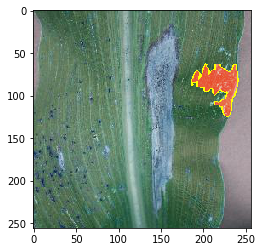

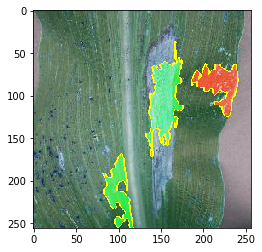

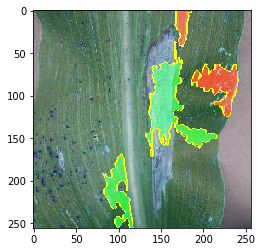

In [40]:
display_region_range(exp, [1,3,5])

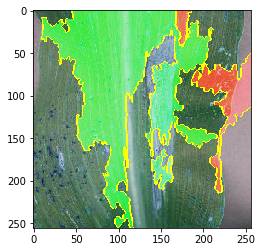

In [41]:
display_region_range(exp, [10])